In [1]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#OTHER
from keras.models import Sequential
import tensorflow as tf
#import tensorflow_datasets as tfds
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
from numpy import *
from PIL import Image
#import theano

In [2]:
#setting up path to images
database_path = Path("fire_dataset")
image_path = list(database_path.glob(r"*/*.png"))

In [3]:
image_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],image_path))

In [4]:
print("FIRE: ", image_labels.count("fire_images"))
print("NO_FIRE: ", image_labels.count("non_fire_images"))

FIRE:  755
NO_FIRE:  244


In [5]:
#transform to dataframe and shuffle
image_path_series = pd.Series(image_path,name="PNG").astype(str)
image_labels_series = pd.Series(image_labels,name="CATEGORY")
image_labels_series.replace({"non_fire_images":"NO_FIRE","fire_images":"FIRE"},inplace=True)
image_train_df = pd.concat([image_path_series,image_labels_series],axis=1)
image_train_df = image_train_df.sample(frac=1).reset_index(drop=True)
image_train_df.head()
image_train_df.shape

(999, 2)

In [6]:
#remove broken image
remove_PNG = 'fire_dataset/non_fire_images/non_fire.189.png'
image_train_df = image_train_df.loc[~(image_train_df.loc[:,'PNG'] == remove_PNG),:]
print(image_train_df.loc[image_train_df.loc[:,'PNG'] == remove_PNG,:])

Empty DataFrame
Columns: [PNG, CATEGORY]
Index: []


In [7]:
image_train_df.head()

PNG CATEGORY
0           fire_dataset\fire_images\fire.83.png     FIRE
1          fire_dataset\fire_images\fire.356.png     FIRE
2          fire_dataset\fire_images\fire.582.png     FIRE
3  fire_dataset\non_fire_images\non_fire.222.png  NO_FIRE
4          fire_dataset\fire_images\fire.204.png     FIRE

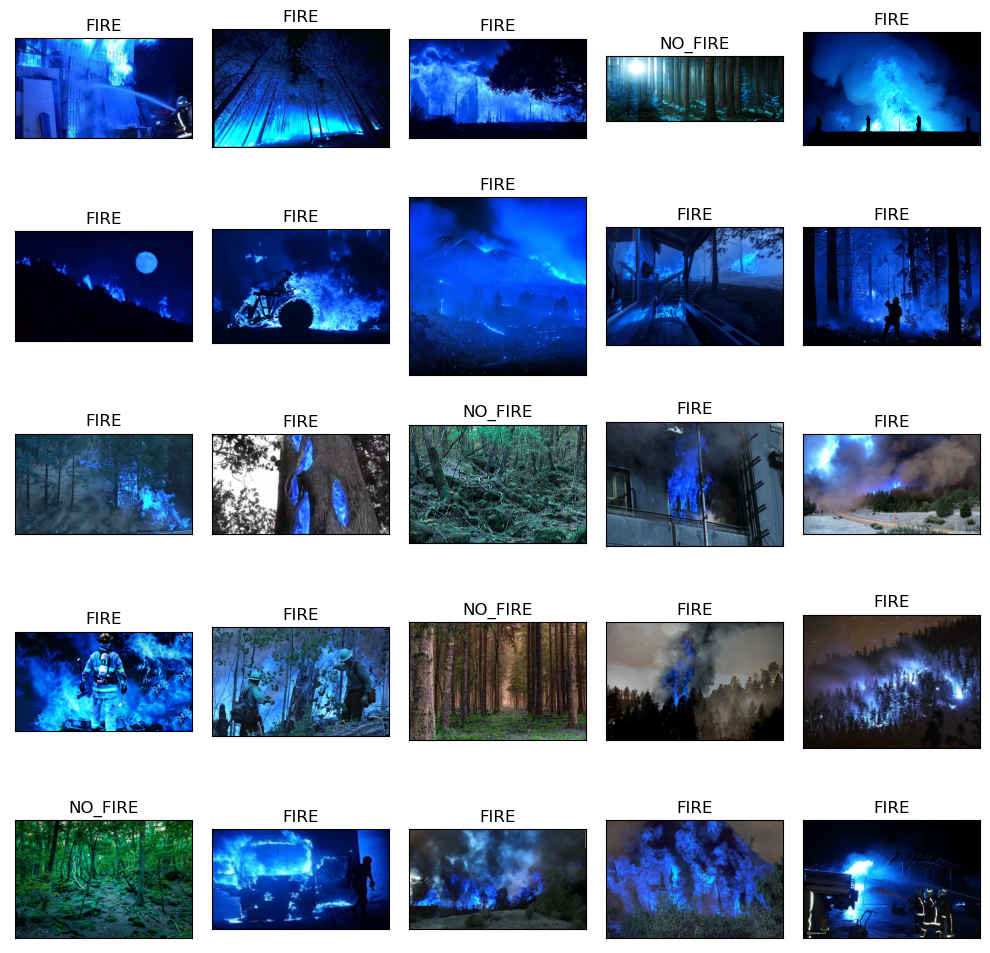

In [8]:
#sample images
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(image_train_df["PNG"][i]))
    ax.set_title(image_train_df["CATEGORY"][i])
plt.tight_layout()
plt.show()

In [9]:
#bar graph of dataset
#sns.countplot(image_train_df["CATEGORY"])
#plt.show()

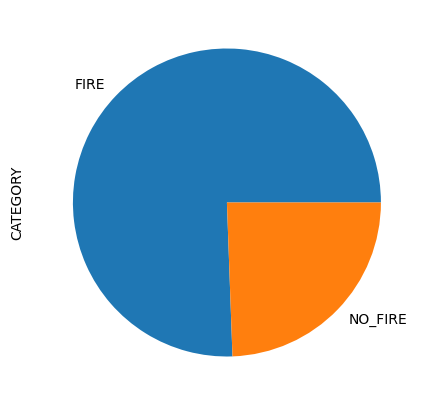

In [10]:
#pie graph of dataset
image_train_df['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()

In [11]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [12]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [13]:
Train_Data,Test_Data = train_test_split(image_train_df,train_size=0.8,random_state=42,shuffle=True)

In [14]:
print("TRAIN SHAPE: ",Train_Data.shape)
print("TEST SHAPE: ",Test_Data.shape)

TRAIN SHAPE:  (799, 2)
TEST SHAPE:  (200, 2)


In [15]:
print(Test_Data["CATEGORY"].value_counts())

FIRE       147
NO_FIRE     53
Name: CATEGORY, dtype: int64


In [16]:
encode = LabelEncoder()

In [17]:
For_Prediction_Class = encode.fit_transform(Test_Data["CATEGORY"])

In [18]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="training")

Found 720 validated image filenames belonging to 2 classes.


In [19]:
Validation_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="validation")

Found 79 validated image filenames belonging to 2 classes.


In [20]:
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                 x_col="PNG",
                                                 y_col="CATEGORY",
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=32)

Found 200 validated image filenames belonging to 2 classes.


In [21]:
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [22]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [23]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [24]:
print("TRAIN: ")
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)
print("---"*20)
print("VALIDATION: ")
print(Validation_IMG_Set.class_indices)
print(Validation_IMG_Set.classes[0:5])
print(Validation_IMG_Set.image_shape)
print("---"*20)
print("TEST: ")
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

TRAIN: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 0, 0, 0, 0]
(256, 256, 3)
------------------------------------------------------------
VALIDATION: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 0, 0, 0, 0]
(256, 256, 3)
------------------------------------------------------------
TEST: 
{'FIRE': 0, 'NO_FIRE': 1}
[1, 0, 0, 1, 0]
(256, 256, 3)


In [25]:
#LeNet Architecture

model = tf.keras.Sequential([
    #1st conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #2nd conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #3rd conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #4th conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2,  activation=tf.nn.softmax)
])

In [26]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
history = model.fit(Train_IMG_Set, epochs = 50, verbose = 1, validation_data =Validation_IMG_Set)

Epoch 1/50
23/23 [==============================] - 40s 2s/step - loss: 0.4732 - accuracy: 0.7653 - val_loss: 0.2621 - val_accuracy: 0.8861
Epoch 2/50
23/23 [==============================] - 32s 1s/step - loss: 0.2593 - accuracy: 0.8944 - val_loss: 0.1683 - val_accuracy: 0.9241
Epoch 3/50
23/23 [==============================] - 31s 1s/step - loss: 0.2438 - accuracy: 0.9153 - val_loss: 0.1518 - val_accuracy: 0.9494
Epoch 4/50
23/23 [==============================] - 31s 1s/step - loss: 0.1549 - accuracy: 0.9375 - val_loss: 0.0708 - val_accuracy: 0.9494
Epoch 5/50
23/23 [==============================] - 29s 1s/step - loss: 0.2038 - accuracy: 0.9181 - val_loss: 0.1535 - val_accuracy: 0.9114
Epoch 6/50
23/23 [==============================] - 31s 1s/step - loss: 0.1474 - accuracy: 0.9472 - val_loss: 0.1005 - val_accuracy: 0.9620
Epoch 7/50
23/23 [==============================] - 30s 1s/step - loss: 0.1312 - accuracy: 0.9597 - val_loss: 0.0715 - val_accuracy: 0.9873
Epoch 8/50
23/23 [==

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

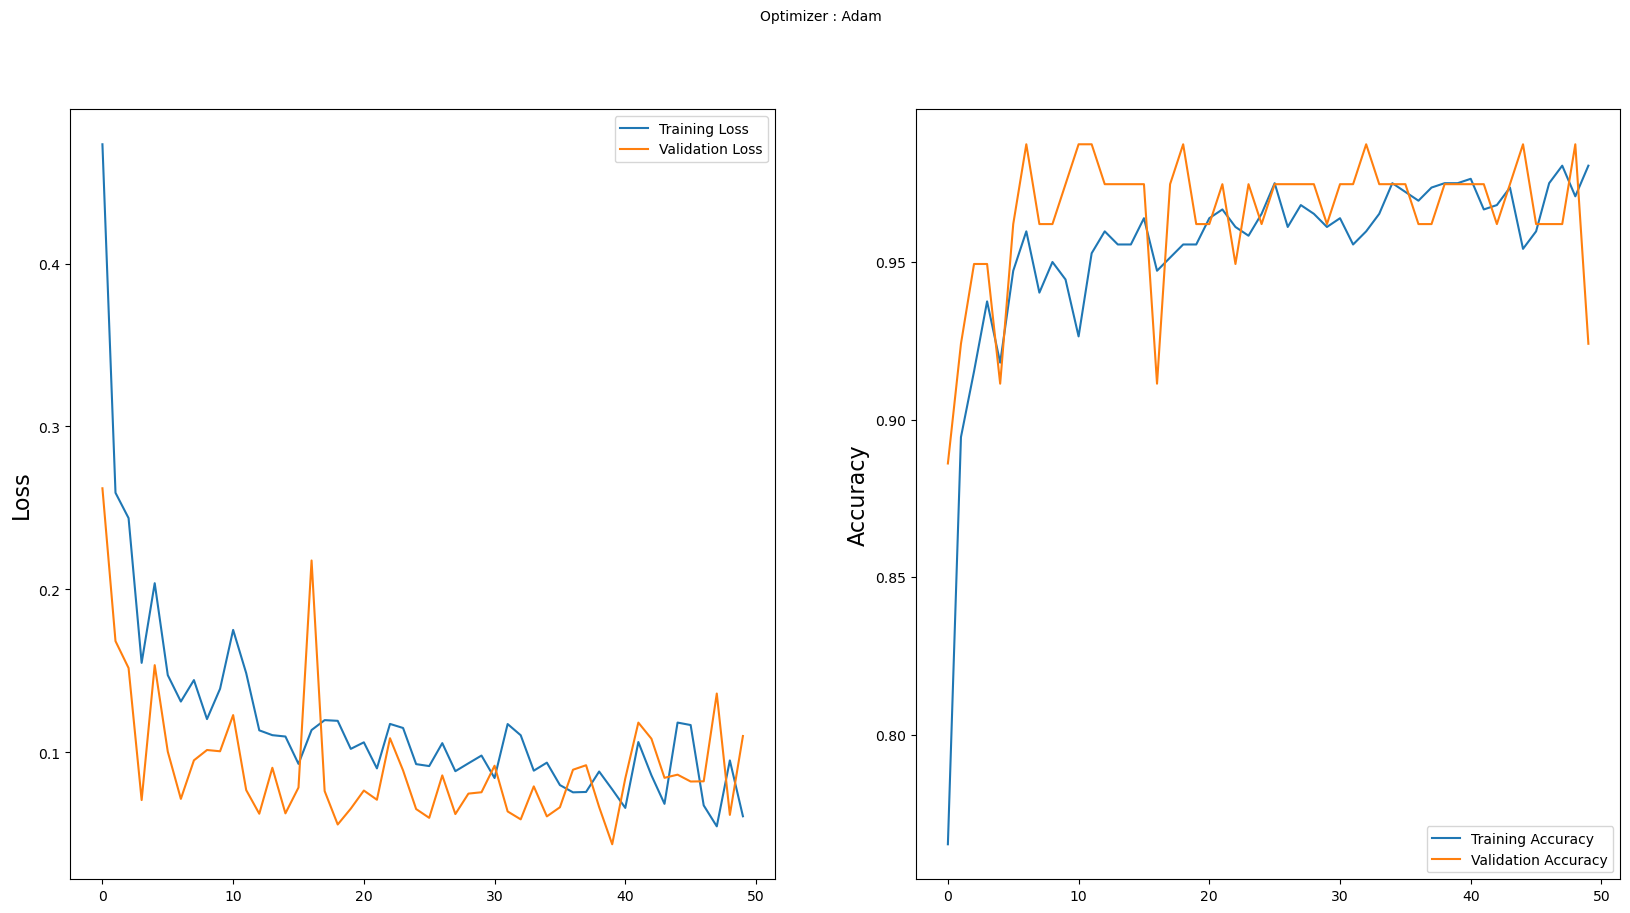

In [29]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Model_Results = model.evaluate(Test_IMG_Set)
# print("LOSS:  " + "%.4f" % Model_Results[0])
# print("ACCURACY:  " + "%.2f" % Model_Results[1])
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

7/7 [==============================] - 5s 699ms/step - loss: 0.1126 - accuracy: 0.9650
The current model achieved a categorical accuracy of 96.5%!


In [31]:
#Prediction_One = model.predict(Test_IMG_Set)
#Prediction_One = Prediction_One.argmax(axis=-1)
#Predict_Class = model.predict_classes(Test_IMG_Set)
predictions = model.predict(Test_IMG_Set)
Predict_Class = np.argmax(predictions, axis=1)

In [32]:
#confusion matrix and other metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
print(confusion_matrix(For_Prediction_Class,Predict_Class))
print(classification_report(For_Prediction_Class,Predict_Class))

[[106  41]
 [ 34  19]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       147
           1       0.32      0.36      0.34        53

    accuracy                           0.62       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.64      0.62      0.63       200



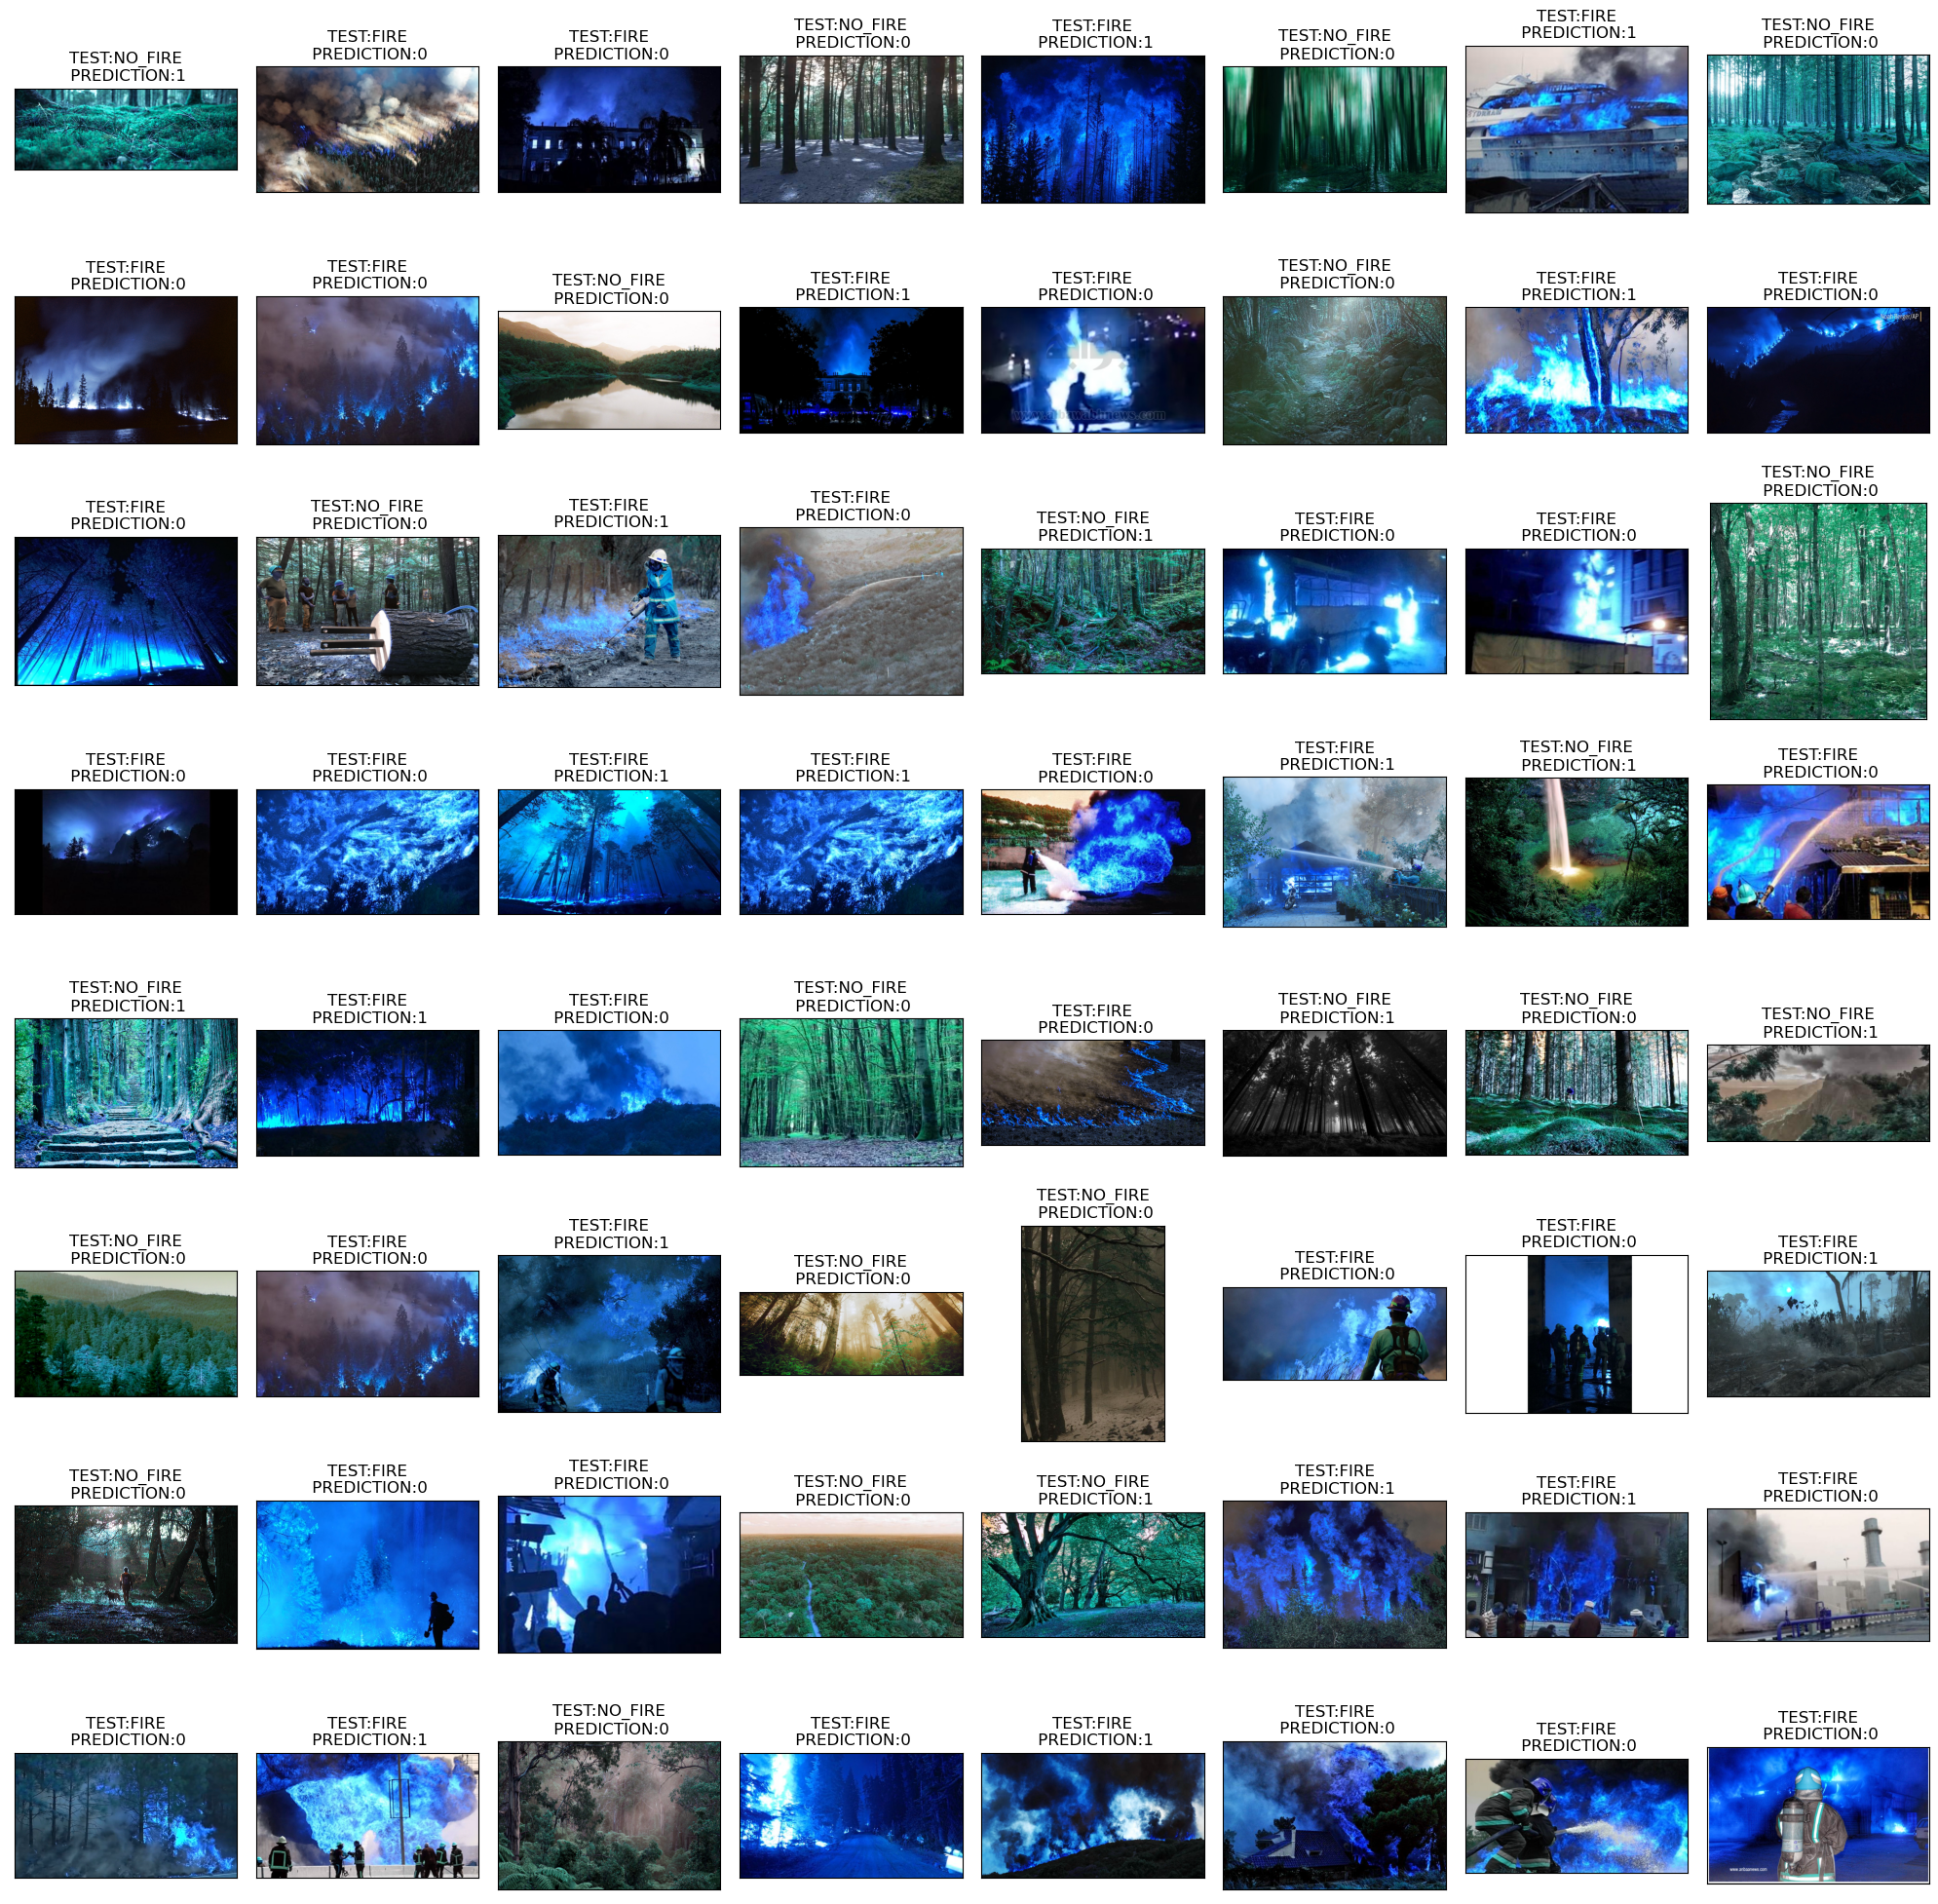

In [33]:
#images with predicted labels
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(Test_Data["PNG"].iloc[i]))
    ax.set_title(f"TEST:{Test_Data.CATEGORY.iloc[i]}\n PREDICTION:{Predict_Class[i]}")
plt.tight_layout()
plt.show()